In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from nb_005 import *

# Pascal

## Setup

In [44]:
PATH = Path('data/pascal')
JPEG_PATH = PATH/'VOCdevkit'/'VOC2007'/'JPEGImages'

In [6]:
import json
trn_j = json.load((PATH / 'pascal_train2007.json').open())

In [45]:
classes = {o['id']:o['name'] for o in trn_j['categories']}
filenames = {o['id']:JPEG_PATH/o['file_name'] for o in trn_j['images']}
annotations = [{'img_id': o['image_id'], 
                'class': classes[o['category_id']], 
                'bbox':o['bbox']} for o in trn_j['annotations'] if not o['ignore']]

In [46]:
len(annotations)

6301

In [47]:
annot_by_img = collections.defaultdict(list)
for annot in annotations:
    annot_by_img[annot['img_id']].append({'class': annot['class'], 'bbox': annot['bbox']})

In [48]:
len(annot_by_img)

2501

In [114]:
biggest_bb = {}
for id in filenames.keys():
    size,best = 0,0
    for i,o in enumerate(annot_by_img[id]):
        o_sz = o['bbox'][2] * o['bbox'][3]
        if size < o_sz:
            size,best = o_sz,i
    biggest_bb[id] = annot_by_img[id][best]

In [115]:
ids = np.array(list(filenames.keys()))
ids = np.random.permutation(ids)
split = int(len(filenames) * 0.2)
train_fns = [filenames[i] for i in ids[split:]]
valid_fns = [filenames[i] for i in ids[:split]]

In [116]:
bboxes = {}
for i in filenames.keys():
    bb = biggest_bb[i]['bbox']
    bboxes[i] = [[bb[1],bb[0]], [bb[3]+bb[1], bb[2]+bb[0]]]

train_bbs = [bboxes[i] for i in ids[split:]]
valid_bbs = [bboxes[i] for i in ids[:split]]

In [117]:
@dataclass
class CoordTargetDataset(Dataset):
    x_fns:List[Path]; bbs:List[List[float]]
    def __post_init__(self): assert len(self.x_fns)==len(self.bbs)
    def __repr__(self): return f'{type(self).__name__} of len {len(self.x_fns)}'
    def __len__(self): return len(self.x_fns)
    def __getitem__(self, i): return open_image(self.x_fns[i]), self.bbs[i]

In [118]:
train_ds = CoordTargetDataset(train_fns, train_bbs)
valid_ds = CoordTargetDataset(valid_fns, valid_bbs)

In [119]:
from matplotlib import patches, patheffects
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def bb_hw(a): return np.array([a[0][1],a[0][0],a[1][1]-a[0][1],a[1][0]-a[0][0]])
    
def show_img_bb(img, bb, ax=None):
    if not ax: fig,ax = plt.subplots()
    ax.imshow(img.numpy().transpose(1,2,0))
    draw_rect(ax, bb_hw(bb))

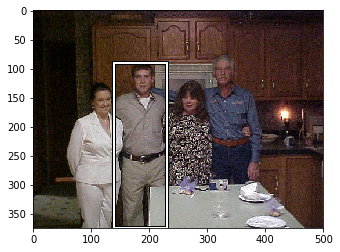

In [129]:
show_img_bb(*train_ds[0])

In [130]:
train_bbs[0]

[[91, 138], [375, 230]]

In [131]:
biggest_bb[ids[split]]

{'class': 'person', 'bbox': [138, 91, 92, 284]}

In [132]:
annot_by_img[ids[split]]

[{'class': 'person', 'bbox': [59, 125, 97, 250]},
 {'class': 'person', 'bbox': [138, 91, 92, 284]},
 {'class': 'person', 'bbox': [220, 120, 91, 182]},
 {'class': 'person', 'bbox': [300, 80, 90, 223]},
 {'class': 'diningtable', 'bbox': [198, 297, 268, 78]}]

In [ ]:
patches.Rectangle()